In [1]:
# Distribution ✨ jit ❇ Demo 💪 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# %load_ext autoreload
# %autoreload 2
# %env "WANDB_NOTEBOOK_NAME" "run.ipynb" # ❕same as notebook
# from jax.config import config
# config.update('jax_disable_jit', True)

In [2]:
from functools import partial

import jax
from jax import pmap, grad
from jax import numpy as jnp
from jax import random as rnd
from flax.training.train_state import TrainState
from flax.core.frozen_dict import FrozenDict	
import optax

from pyfig import Pyfig
from hwat import FermiNet, compute_ke_b, compute_pe, init_walker
import wandb


In [3]:
import numpy as np

def collect_stats(k, v, new_d, p='tr', suf='', sep='/', sep_long='-'):
	depth = p.count('/')
	if depth > 1:
		sep = sep_long
	if isinstance(v, dict):
		for k_sub,v_sub in v.items():
			collect_stats(k, v_sub, new_d, p=(p+sep+k_sub))
	else:
		new_d[p+sep+k+suf] = v
	return new_d

def compute_metrix(d:dict, mode='tr'):
	pattern_ignore = []
	fancy = dict(
		pe		= r'$V(X)',    				
		ke		= r'$\nabla^2',    		
		e		= r'$E',						
		log_psi	= r'$\log\psi', 			
		deltar	= r'$\delta_\mathrm{r}',	
		x		= r'$r_\mathrm{e}',
	)
	_d = {}
	for k,v in d.items():
		k = fancy.get(k, k)
		v = jax.device_get(v)
		
		if isinstance(v, FrozenDict):
			v = v.unfreeze()
		
		v_mean = jax.tree_map(lambda x: x.mean(), v) if not np.isscalar(v) else v
		v_std = jax.tree_map(lambda x: x.std(), v) if not np.isscalar(v) else 0.

		if 'Dense' in k:
			group = mode + '/param'
		else:
			group = mode
		
		_d = collect_stats(k, v_mean, _d, p=group, suf=r'_\mu$')
		_d = collect_stats(k, v_std, _d, p=group+'/std', suf=r'_\sigma$')

	# return {k:v for k,v in _d.items() if not any([regex.match(k, pat) for pat in pattern_ignore])}
	return {k:v for k,v in _d.items() if not any([pat in k for pat in pattern_ignore])}

In [4]:
# c.partial instead of state


args = {}
args = {
	'l_e':[4,], 
	'a_z':[4,], 
	'n_u': 2,
	'n_b': 512, 
	'n_sv': 32, 
	'n_pv': 32, 
	'corr_len': 10, 
	'n_step': 100000, 
	'log_metric_step': 50, 
	'exp_name':'junk'
}
c = Pyfig(wandb_mode='online', args=args, get_sys_arg=False)

@partial(jax.pmap, axis_name='dev', in_axes=(0,0))
def create_train_state(rng, r):
	model = FermiNet(
		n_e=c.data.n_e,
		n_u=c.data.n_u,
		n_d=c.data.n_d,
		n_det=1,
		n_fb=c.model.n_fb,
		n_pv=c.model.n_pv,
		a=c.data.a

	)
	model = c.partial(FermiNet) 

	params = model.init(rng, r)
	return TrainState.create(
		apply_fn=model.apply, 
		params=params, 
		tx=optax.chain(optax.clip_by_block_rms(1.),optax.adamw(0.001))
	)
 

print(
	c.data.a,
	c.data.a_z,
	c.data.n_d, 
	
	c.data.n_u, 
	c.data.n_b

)


@partial(pmap, in_axes=(0, 0))
def train_step(state, r_step):

	ke = compute_ke_b(state, r_step)
	pe = compute_pe(r_step, c.data.a, c.data.a_z)
	e = pe + ke
	assert pe.size == ke.size == r_step.shape[0]
	
	e_mean_dist = jnp.mean(jnp.abs(jnp.median(e) - e))
	e_clip = jnp.clip(e, a_min=e-5*e_mean_dist, a_max=e+5*e_mean_dist)

	def loss(params):
		return ((e_clip - e_clip.mean())*state.apply_fn(params, r_step)).mean()
	
	grads = grad(loss)(state.params)
	loss_v = loss(state.params)
	state = state.apply_gradients(grads=grads)
	return state, (grads, e, pe, ke, loss_v)


def keep_in_nnn_boundary(r, n=1.):
	r = r/n
	r = jnp.fmod(r, 1.)
	r = r*n
	return r

def sample_ii(rng, state, r_0):
	
	acc = 0.0
	for i in jnp.arange(1, c.data.corr_len+1):
		rng, rng_alpha = rnd.split(rng, 2)

		p_0 = (jnp.exp(state.apply_fn(state.params, r_0))**2)
		r_1 = r_0 + rnd.normal(rng, r_0.shape, dtype=r_0.dtype)*0.02
		
		p_1 = jnp.exp(state.apply_fn(state.params, r_1))**2
		p_1 = jnp.where(jnp.isnan(p_1), 0., p_1)

		p_mask = (p_1/p_0) > rnd.uniform(rng_alpha, p_1.shape)
		
		r_0 = jnp.where(p_mask[..., None, None], r_1, r_0)
		
		acc += jnp.mean(p_mask)
	
	return r_0, acc/i

def gen_rng(rng):
	rng, rng_p = jnp.split(rnd.split(rng, c.n_device+1), [1,])
	return rng.squeeze(), rng_p	

rng, rng_p = gen_rng(rnd.PRNGKey(c.seed))

r = init_walker(rng_p, n_d=c.data.n_d, n_u=c.data.n_u, n_b=c.data.n_b, center=c.data.a)

state = create_train_state(rng_p, r)

metro_hast = pmap(sample_ii, in_axes=(0,0,0))

model = pmap(c.partial(FermiNet).apply, in_axes=(0,0))


collect = {'r': [], 'pe': [], 'ke': []}
wandb.define_metric("*", step_metric="tr/step")
for step in range(1, c.n_step+1):
	rng, rng_p = gen_rng(rng)

	r, acc = metro_hast(rng_p, state, r)
	
	if step < 10000:
		r = keep_in_nnn_boundary(r, 5.)
		if step % 50 == 0:
			print(r.mean(), r.std())
	
	log_psi = model(state.params, r)
	state, (grads, e, pe, ke, loss) = train_step(state, r)

	data = dict(
		e=e, 
		pe=pe, 
		ke=ke, 
		grads=grads, 
		loss=loss, 
		acc=acc, 
		r=r, 
		params=state.params,
		log_psi=log_psi
	)

	n_wb = 50
	if not (step % n_wb):
		metrix = compute_metrix(data)
		wandb.log({'tr/step':step, **metrix})
		m = ' '.join([f'{k} {v:.5f} ' for k,v in metrix.items() if 'E_' in k])
	
		if not (step % (5*n_wb)):
			print(f'Step {step} {e.mean()}')

	if jnp.isnan(e).any():
		break


setting  l_e
setting  a_z
can't set attribute 'a_z' 
 Unmerged {k}
setting  n_u
setting  n_b
setting  n_sv
setting  n_pv
setting  corr_len
setting  n_step
setting  log_metric_step
setting  exp_name
Path:  /home/amawi/projects/hwat/exp/junk/ZA5iqJb ✅
System 
{'a': array([[0., 0., 0.]]),
 'a_z': array([4.]),
 'acc_target': 0.5,
 'corr_len': 10,
 'equil_len': 10000,
 'l_e': [4],
 'n_b': 512,
 'n_d': 2,
 'n_e': 4,
 'n_u': 2,
 'with_sign': False}
Model 
{'n_det': 1,
 'n_fb': 2,
 'n_fbv': 160,
 'n_pv': 32,
 'n_sv': 32,
 'terms_p_emb': ['rr'],
 'terms_s_emb': ['r', 'ra']}


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xmax1. Use `wandb login --relogin` to force relogin


run:  xmax1/hwat/s7yt36j8 ✅
[[0. 0. 0.]] [4.] 2 2 512
-0.005009722 1.0094676
-0.003410249 1.0205011
-0.0015536824 1.0209513
0.0009563196 1.0271261
-0.00011759128 1.0287
Step 250 -8.429386138916016
-0.0014657504 1.0273893
-0.012366566 1.0092809
-0.028459381 0.99868006
-0.033029526 0.97654444
-0.029716244 0.9495104
Step 500 -10.888696670532227
-0.03436826 0.92772293
-0.038225662 0.8990371
-0.03593526 0.88745636
-0.03418088 0.87979305
-0.032636583 0.8788822
Step 750 -11.707110404968262
-0.038239155 0.85965544
-0.03455671 0.83814806
-0.040260106 0.8231198
-0.05596895 0.8141594
-0.057868488 0.82702833
Step 1000 -12.457928657531738
-0.048981816 0.8269461
-0.039842684 0.81575084
-0.038366534 0.81881535
-0.034749255 0.8336343
-0.03202331 0.83767635
Step 1250 -11.238162994384766
-0.024105301 0.8288508
-0.023406263 0.8180366
-0.017002426 0.7963172
-0.016672354 0.7819012
-0.0152120385 0.77024734
Step 1500 -12.63931941986084
-0.00990377 0.77017695
-0.010590471 0.7766814
-0.000964356 0.7683209
0.00

In [5]:
# if step < 5000:
	# 	r = init_walker(rng_p, n_d=c.data.n_d, n_u=c.data.n_u, n_b=c.data.n_b, center=c.data.a, std=0.1)
	# 	for i in range(10):
	# 		r, acc, deltar = metro_hast(rng_p, state, r, deltar)
	# else:
	# 	for i in range(10):
	# 		r, acc, deltar = metro_hast(rng_p, state, r, deltar)



# def sample_ii(rng, state, r_0, deltar):
	
# 	deltar_1 = jnp.clip(deltar + 0.001*rnd.normal(rng,deltar.shape), a_min=0.1, a_max=0.5)
	
# 	deltar_both  = [deltar, deltar_1]
# 	acc_both = []
# 	for deltar in deltar_both:
# 		p_0 = (jnp.exp(state.apply_fn(state.params, r_0))**2)
		
# 		acc = []
# 		for _ in jnp.arange(1, c.data.corr_len//2):
# 			rng, rng_alpha = rnd.split(rng, 2)

# 			r_1 = r_0 + rnd.normal(rng, r_0.shape, dtype=r_0.dtype)*deltar
			
# 			p_1 = jnp.exp(state.apply_fn(state.params, r_1))**2
# 			p_1 = jnp.where(jnp.isnan(p_1), 0., p_1)

# 			p_mask = (p_1/p_0) > rnd.uniform(rng_alpha, p_1.shape)
			
# 			p_0 = jnp.where(p_mask, p_1, p_0)
# 			r_0 = jnp.where(p_mask[..., None, None], r_1, r_0)
			
# 			acc += [jnp.mean(p_mask)]
# 		acc_both += [sum(acc)/len(acc)]

# 	deltar = jnp.where(jnp.abs(0.5-acc_both[0])<jnp.abs(0.5-acc_both[1]), deltar, deltar_1)
	
# 	return r_0, (acc_both[0]+acc_both[1])/2., deltar

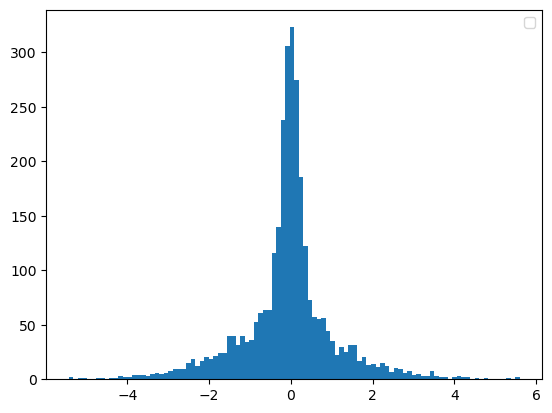

In [6]:
import matplotlib.pyplot as plt

plt.hist(r[0][:, :2].reshape(-1), bins=100)
plt.legend()
plt.show()

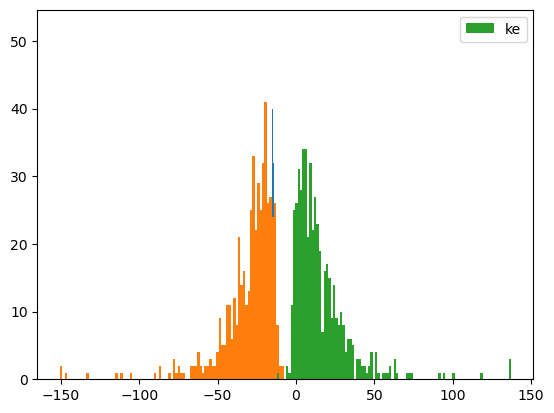

In [7]:
import matplotlib.pyplot as plt

plt.hist(e, bins=100)
plt.hist(pe, bins=100)
plt.hist(ke, bins=100, label='ke')
plt.legend()
plt.show()

In [8]:

def create_train_state_i(rng, r):
    model = c.partial(FermiNet)  
    params = model.init(rng, r)
    return TrainState.create(apply_fn=model.apply, params=params, tx=optax.adam(0.01))

state = create_train_state_i(rng, r[0])

deltar_i = deltar[0]
r_0 = r[0]


p_0 = (jnp.exp(state.apply_fn(state.params, r_0))**2)

for _ in jnp.arange(1, c.data.corr_len):
	rng, rng_alpha = rnd.split(rng, 2)

	r_1 = r_0 + rnd.normal(rng, r_0.shape, dtype=r_0.dtype)*deltar_i
	p_1 = jnp.exp(state.apply_fn(state.params, r_1))**2

	p_mask = (p_1/p_0) > rnd.uniform(rng_alpha, p_1.shape)
	
	p_0 = jnp.where(p_mask, p_1, p_0)
	r_0 = jnp.where(p_mask[..., None, None], r_1, r_0)	
	print(p_mask.mean())



NameError: name 'deltar' is not defined

In [ ]:
r

ShardedDeviceArray([[[[ 1.9007555e+00,  1.1410671e+00, -6.6881738e+00],
                      [-2.2503405e+01,  2.8869953e+01, -2.1502833e+00],
                      [ 4.6406641e+00,  3.9603489e+01, -3.0636536e+01],
                      [ 3.2805979e-02, -1.6124485e+01, -5.8321023e+00]],

                     [[-1.1880143e+00,  4.8265924e+00, -2.9804328e-01],
                      [-2.3986162e+01,  1.1771825e+01,  2.6481308e+01],
                      [-1.0560344e+00,  4.9753788e+01,  2.1829014e+01],
                      [ 7.9505873e-01,  3.0236721e+00, -4.5025282e+00]],

                     [[-3.0717777e+01,  2.2264914e+01,  5.9241104e+00],
                      [ 1.1509624e+00,  1.1934803e+00,  1.3152162e+00],
                      [-3.4493279e+01,  3.3944008e+01, -8.2277260e+00],
                      [ 1.1018317e+00, -1.1538062e+00, -8.3900633e+00]],

                     ...,

                     [[-3.3702240e+01,  7.8377223e+00,  2.6325283e+01],
                      [-1.01770

In [ ]:
r

ShardedDeviceArray([[[[ 1.9007555e+00,  1.1410671e+00, -6.6881738e+00],
                      [-2.2503405e+01,  2.8869953e+01, -2.1502833e+00],
                      [ 4.6406641e+00,  3.9603489e+01, -3.0636536e+01],
                      [ 3.2805979e-02, -1.6124485e+01, -5.8321023e+00]],

                     [[-1.1880143e+00,  4.8265924e+00, -2.9804328e-01],
                      [-2.3986162e+01,  1.1771825e+01,  2.6481308e+01],
                      [-1.0560344e+00,  4.9753788e+01,  2.1829014e+01],
                      [ 7.9505873e-01,  3.0236721e+00, -4.5025282e+00]],

                     [[-3.0717777e+01,  2.2264914e+01,  5.9241104e+00],
                      [ 1.1509624e+00,  1.1934803e+00,  1.3152162e+00],
                      [-3.4493279e+01,  3.3944008e+01, -8.2277260e+00],
                      [ 1.1018317e+00, -1.1538062e+00, -8.3900633e+00]],

                     ...,

                     [[-3.3702240e+01,  7.8377223e+00,  2.6325283e+01],
                      [-1.01770

In [ ]:
from jax import vmap

@partial(jax.pmap, axis_name='dev', in_axes=(0,0))
def create_train_state(rng, r):
    model = c.partial(FermiNet, with_sign=True)  
    params = model.init(rng, r)
    return TrainState.create(apply_fn=model.apply, params=params, tx=optax.adam(0.01))
    
state = create_train_state(rng, r)

@partial(vmap, in_axes=(0, None, None))
def swap_rows(r, i_0, i_1):
    return r.at[[i_0,i_1], :].set(r[[i_1,i_0], :])

@partial(pmap, in_axes=(0, 0))
def check_antisym(state, r):
    log_psi_0, sgn_0 = state.apply_fn(state.params, r)
    r_swap_u = swap_rows(r, 0, 1)
    log_psi_u, sgn_u = state.apply_fn(state.params, r_swap_u)
    log_psi_d = jnp.zeros_like(log_psi_0)
    sgn_d = jnp.zeros_like(sgn_0)
    if not c.data.n_d == 0:
        r_swap_d = swap_rows(r, c.data.n_u, c.data.n_u+1)
        log_psi_d, sgn_d = state.apply_fn(state.params, r_swap_d)
    return (log_psi_0, log_psi_u, log_psi_d), (sgn_0, sgn_u, sgn_d), (r, r_swap_u, r_swap_d)

res = check_antisym(state, r)

(log_psi, log_psi_u, log_psi_d), (sgn, sgn_u, sgn_d), (r, r_swap_u, r_swap_d) = res
for ei, ej, ek in zip(r[0,0], r_swap_u[0,0], r_swap_d[0,0]):
    print(ei, ej, ek)  # Swap Correct
for lpi, lpj, lpk in zip(log_psi[0], log_psi_u[0], log_psi_d[0]):
    print(lpi, lpj, lpk)  # Swap Correct
for lpi, lpj, lpk in zip(sgn[0], sgn_u[0], sgn_d[0]):
    print(lpi, lpj, lpk)  # Swap Correct

ValueError: pmap got inconsistent sizes for array axes to be mapped:
  * one axis had size 2: axis 0 of argument rng of type uint32[2];
  * one axis had size 1: axis 0 of argument r of type float32[1,512,4,3]

In [ ]:
from jax import vmap

def check_antisym(c, rng, r):
	n_u, n_d, = c.data.n_u, c.data.n_d
	r = r[:, :4]
	
	@partial(vmap, in_axes=(0, None, None))
	def swap_rows(r, i_0, i_1):
		return r.at[[i_0,i_1], :].set(r[[i_1,i_0], :])

	@partial(jax.pmap, axis_name='dev', in_axes=(0,0))
	def _create_train_state(rng, r):
		model = c.partial(FermiNet, with_sign=True)  
		params = model.init(rng, r)['params']
		return TrainState.create(apply_fn=model.apply, params=params, tx=c.opt.tx)
	
	state = _create_train_state(rng, r)

	@partial(pmap, in_axes=(0, 0))
	def _check_antisym(state, r):
		log_psi_0, sgn_0 = state.apply_fn(state.params, r)
		r_swap_u = swap_rows(r, 0, 1)
		log_psi_u, sgn_u = state.apply_fn(state.params, r_swap_u)
		log_psi_d = jnp.zeros_like(log_psi_0)
		sgn_d = jnp.zeros_like(sgn_0)
		if not n_d == 0:
			r_swap_d = swap_rows(r, n_u, n_u+1)
			log_psi_d, sgn_d = state.apply_fn(state.params, r_swap_d)
		return (log_psi_0, log_psi_u, log_psi_d), (sgn_0, sgn_u, sgn_d), (r, r_swap_u, r_swap_d)

	res = _check_antisym(state, r)

	(log_psi, log_psi_u, log_psi_d), (sgn, sgn_u, sgn_d), (r, r_swap_u, r_swap_d) = res
	for ei, ej, ek in zip(r[0,0], r_swap_u[0,0], r_swap_d[0,0]):
		print(ei, ej, ek)  # Swap Correct
	for lpi, lpj, lpk in zip(log_psi[0], log_psi_u[0], log_psi_d[0]):
		print(lpi, lpj, lpk)  # Swap Correct
	for lpi, lpj, lpk in zip(sgn[0], sgn_u[0], sgn_d[0]):
		print(lpi, lpj, lpk)  # Swap Correct

In [ ]:

state.params['params']



FrozenDict({
    Dense_0: {
        bias: ShardedDeviceArray([[0.01459372, 0.00997529, 0.01267799, 0.0786592 ,
                             0.04518591, 0.01598902, 0.01946411, 0.0160135 ,
                             0.0820886 , 0.066571  , 0.07754244, 0.05884545,
                             0.076667  , 0.0361336 , 0.01449547, 0.03578294,
                             0.02859007, 0.06440564, 0.09925729, 0.07102094,
                             0.07148563, 0.06547641, 0.04870448, 0.03848153,
                             0.06832297, 0.02668134, 0.02206043, 0.09556375,
                             0.04705796, 0.07842465, 0.04566721, 0.04030572]],                   dtype=float32),
        kernel: ShardedDeviceArray([[[ 2.69128174e-01, -5.06307244e-01,  1.86619103e-01,
                              -2.58631647e-01,  2.83852220e-01, -8.21515843e-02,
                              -3.84322810e-03, -3.50300491e-01, -4.67570461e-02,
                               2.10296005e-01, -4.19384778e-01,